### Mnist

In [1]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [2]:
#필요한 모듈 import

import tempfile
import os

import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

import tensorflow as tf
import numpy as np

from tensorflow import keras

import pathlib

tflite_models_dir = pathlib.Path("/tmp/tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

import tensorflow_model_optimization as tfmot

### BaseModel training and model save

In [3]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

# Define the model architecture
model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28)),
  tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
  tf.keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10)
])

# Train the digit classification model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])
model.fit(
  train_images,
  train_labels,
  epochs=5,
  validation_data=(test_images, test_labels)
)
 

_, baseline_model_accuracy = model.evaluate(
    test_images, test_labels, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)

_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

Epoch 1/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.2977 - accuracy: 0.9153 - val_loss: 0.1388 - val_accuracy: 0.9602
Epoch 2/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1183 - accuracy: 0.9657 - val_loss: 0.0913 - val_accuracy: 0.9714
Epoch 3/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0868 - accuracy: 0.9746 - val_loss: 0.0751 - val_accuracy: 0.9756
Epoch 4/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0701 - accuracy: 0.9790 - val_loss: 0.0672 - val_accuracy: 0.9778
Epoch 5/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0600 - accuracy: 0.9822 - val_loss: 0.0622 - val_accuracy: 0.9792
Baseline test accuracy: 0.979200005531311
Saved baseline model to: /tmp/tmp4gybi08f.h5


### 필요한 함수

In [4]:
# TFLite model 추론
def run_tflite_model(tflite_file, test_image_indices):
    global test_images

    # Initialize the interpreter
    interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    predictions = np.zeros((len(test_image_indices),), dtype=int)
    for i, test_image_index in enumerate(test_image_indices):
        test_image = test_images[test_image_index]
        test_label = test_labels[test_image_index]

        # Check if the input type is quantized, then rescale input data to uint8
        if input_details['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details["quantization"]
            test_image = test_image / input_scale + input_zero_point

        test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
        interpreter.set_tensor(input_details["index"], test_image)
        interpreter.invoke()
        output = interpreter.get_tensor(output_details["index"])[0]

        # Check if the output type is quantized, then rescale output data to float
        if output_details['dtype'] == np.uint8:
            output_scale, output_zero_point = output_details["quantization"]
            test_image = test_image.astype(np.float32)
            test_image = test_image / input_scale + input_zero_point

        predictions[i] = output.argmax()

    return predictions

 

In [5]:
# dynamic tflite 정확도 측정 함수
def devaluate_model(interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # Run predictions on every image in the "test" dataset.
    prediction_digits = []
    for test_image in test_images:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)

    # Run inference.
        interpreter.invoke()

        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
    accurate_count = 0
    for index in range(len(prediction_digits)):
        if prediction_digits[index] == test_labels[index]:
            accurate_count += 1
    accuracy = accurate_count * 1.0 / len(prediction_digits)

    return accuracy

In [6]:
# integer tflite 정확도 측정 함수
def ievaluate_model(tflite_file):
    global test_images
    global test_labels

    test_image_indices = range(test_images.shape[0])
    predictions = run_tflite_model(tflite_file, test_image_indices)

    accuracy = (np.sum(test_labels== predictions) * 100) / len(test_images)

    return accuracy

In [7]:
# tflite 정확도 측정 함수
import numpy as np

def evaluate_model(interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # Run predictions on ever y image in the "test" dataset.
    prediction_digits = []
    for i, test_image in enumerate(test_images):
        if i % 1000 == 0:
            print('Evaluated on {n} results so far.'.format(n=i))
    
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)

        # Run inference.
        interpreter.invoke()

        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)

    print('\n')
    # Compare prediction results with ground truth labels to calculate accuracy.
    prediction_digits = np.array(prediction_digits)
    accuracy = (prediction_digits == test_labels).mean()
    return accuracy

In [8]:
# 모델 사이즈를 측정하기 위한 함수
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
    import os
    import zipfile

    _, zipped_file = tempfile.mkstemp('.zip')
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(file)

    return os.path.getsize(zipped_file)

In [9]:
# 일반적인 값을 표현하기에 충분히 큰 입력 데이터 세트를 제공하는 생성기 함수
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
        yield [input_value]

## 1.weight pruning

In [10]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 4 epochs.
batch_size = 128
epochs = 5
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = train_images.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.90,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]
  
model_for_pruning.fit(train_images, train_labels,
                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)

_, model_for_pruning_accuracy = model_for_pruning.evaluate(
   test_images, test_labels, verbose=0)

model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

################# 정확도 ###############################
print('Baseline test accuracy:', baseline_model_accuracy) 
print('Pruned test accuracy:', model_for_pruning_accuracy)

################# 모델 size ##############################
print('Baseline model size:', get_gzipped_model_size(keras_file))
print('Pruned model size:', get_gzipped_model_size(pruned_keras_file))

Instructions for updating:
Please use `layer.add_weight` method instead.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_reshape  (None, 28, 28, 1)         1         
_________________________________________________________________
prune_low_magnitude_conv2d ( (None, 26, 26, 12)        230       
_________________________________________________________________
prune_low_magnitude_max_pool (None, 13, 13, 12)        1         
_________________________________________________________________
prune_low_magnitude_flatten  (None, 2028)              1         
_________________________________________________________________
prune_low_magnitude_dense (P (None, 10)                40572     
Total params: 40,805
Trainable params: 20,410
Non-trainable params: 20,395
_________________________________________________________________
Epoch 1/5
  1/422 [.....................

## 2.quantization-aware training

In [11]:
quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

q_aware_model.summary()

train_images_subset = train_images[0:1000] # out of 60000
train_labels_subset = train_labels[0:1000]

q_aware_model.fit(train_images_subset, train_labels_subset,
                  batch_size=500, epochs=1, validation_split=0.1)

_, q_aware_model_accuracy = q_aware_model.evaluate(
   test_images, test_labels, verbose=0)

_, quantized_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(q_aware_model, quantized_keras_file, include_optimizer=False)
print('Saved quantized Keras model to:', quantized_keras_file)

################# 정확도 ###############################
print('Baseline test accuracy:', baseline_model_accuracy)
print('Pruned test accuracy:', model_for_pruning_accuracy)
print('Quant test accuracy:', q_aware_model_accuracy)

################# 모델 size ##############################
print('Baseline model size:', get_gzipped_model_size(keras_file))
print('Pruned model size:', get_gzipped_model_size(pruned_keras_file))
print('Quant model size:', get_gzipped_model_size(quantized_keras_file))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quantize_layer (QuantizeLaye (None, 28, 28)            3         
_________________________________________________________________
quant_reshape (QuantizeWrapp (None, 28, 28, 1)         1         
_________________________________________________________________
quant_conv2d (QuantizeWrappe (None, 26, 26, 12)        147       
_________________________________________________________________
quant_max_pooling2d (Quantiz (None, 13, 13, 12)        1         
_________________________________________________________________
quant_flatten (QuantizeWrapp (None, 2028)              1         
_________________________________________________________________
quant_dense (QuantizeWrapper (None, 10)                20295     
Total params: 20,448
Trainable params: 20,410
Non-trainable params: 38
___________________________________________________

## 3.post-training dynamic range quantization

In [12]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
#Optimize.DEFAULT는 for zine에 맞춰서 optmodel = convert
converter.optimizations = [tf.lite.Optimize.DEFAULT]
dynamic_post_quan_tflite_model = converter.convert()

interpreter_dynamic_post_q = tf.lite.Interpreter(model_content=dynamic_post_quan_tflite_model)
input_type = interpreter_dynamic_post_q.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter_dynamic_post_q.get_output_details()[0]['dtype']
print('output: ', output_type)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpw0xrgoj3/assets
input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


In [13]:
dynamic_post_quan_tflite_file = tflite_models_dir/"dynamic_post_quan_tflite_file.tflite"
dynamic_post_quan_tflite_file.write_bytes(dynamic_post_quan_tflite_model)

interpreter_dynamic_post_q.allocate_tensors()
dynamic_post_q_accuracy = devaluate_model(interpreter_dynamic_post_q)

################# 정확도 ###############################
print('Baseline test accuracy:', baseline_model_accuracy)
print('Pruned test accuracy:', model_for_pruning_accuracy)
print('Quant test accuracy:', q_aware_model_accuracy)
print('Dynamic Post-Quant test accuracy:', dynamic_post_q_accuracy)

################# 모델 size ##############################
print('Baseline model size:', get_gzipped_model_size(keras_file))
print('Pruned model size:', get_gzipped_model_size(pruned_keras_file))
print('Quant model size:', get_gzipped_model_size(quantized_keras_file))
print('Dynamic Post-Quant size:', get_gzipped_model_size(dynamic_post_quan_tflite_file))

Baseline test accuracy: 0.979200005531311
Pruned test accuracy: 0.9527999758720398
Quant test accuracy: 0.9524000287055969
Dynamic Post-Quant test accuracy: 0.9526
Baseline model size: 77996
Pruned model size: 17482
Quant model size: 35726
Baseline model size: 5509


## 4.post-training integer quantization

* 참고 사항: integer quantization은  TensorFlow r2.3에 추가 된 API를 사용

In [14]:
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_data_gen
converter2.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 
converter2.inference_input_type = tf.uint8
converter2.inference_output_type = tf.uint8

integer_post_quan_tflite_model = converter2.convert()

interpreter_integer_post_q = tf.lite.Interpreter(model_content=integer_post_quan_tflite_model)
input_type = interpreter_integer_post_q.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter_integer_post_q.get_output_details()[0]['dtype']
print('output: ', output_type)

INFO:tensorflow:Assets written to: /tmp/tmpexu23s7n/assets


INFO:tensorflow:Assets written to: /tmp/tmpexu23s7n/assets


input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


In [15]:
integer_post_quan_tflite_file = tflite_models_dir/"integer_post_quan_tflite_file.tflite"
integer_post_quan_tflite_file.write_bytes(integer_post_quan_tflite_model)

integer_post_q_accuracy = ievaluate_model(integer_post_quan_tflite_file)



################# 정확도 ###############################
print('Baseline test accuracy:', baseline_model_accuracy)
print('Pruned test accuracy:', model_for_pruning_accuracy)
print('Quant test accuracy:', q_aware_model_accuracy)
print('Dynamic Post-Quant test accuracy:', dynamic_post_q_accuracy)
print('Integer Post-Quant test accuracy:' , integer_post_q_accuracy*(1/100))

################# 모델 size ##############################
print('Baseline model size:', get_gzipped_model_size(keras_file))
print('Pruned model size:', get_gzipped_model_size(pruned_keras_file))
print('Quant model size:', get_gzipped_model_size(quantized_keras_file))
print('Dynamic Post-Quant size:', get_gzipped_model_size(dynamic_post_quan_tflite_file))
print('Integer Post-Quant size:', get_gzipped_model_size(integer_post_quan_tflite_file))

Baseline test accuracy: 0.979200005531311
Pruned test accuracy: 0.9527999758720398
Quant test accuracy: 0.9524000287055969
Dynamic Post-Quant test accuracy: 0.9526
Integer Post-Quant test accuracy: 0.9529000000000001
Baseline model size: 77996
Pruned model size: 17482
Quant model size: 35726
Dynamic Post-Quant size: 5509
Integer Post-Quant size: 5848


## 5.post-training float16 quantization

In [16]:
converter3 = tf.lite.TFLiteConverter.from_keras_model(model)
converter3.optimizations = [tf.lite.Optimize.DEFAULT]
converter3.target_spec.supported_types = [tf.float16]

fp16_post_quan_tflite_model = converter3.convert()

interpreter_fp16_post_q = tf.lite.Interpreter(model_content=fp16_post_quan_tflite_model)
input_type = interpreter_fp16_post_q.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter_fp16_post_q.get_output_details()[0]['dtype']
print('output: ', output_type)

INFO:tensorflow:Assets written to: /tmp/tmpya6ah2ck/assets


INFO:tensorflow:Assets written to: /tmp/tmpya6ah2ck/assets


input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


In [17]:
fp16_post_quan_tflite_file = tflite_models_dir/"fp16_post_quan_tflite_file.tflite"
fp16_post_quan_tflite_file.write_bytes(fp16_post_quan_tflite_model)

interpreter_fp16_post_q.allocate_tensors()
fp16_post_q_accuracy = devaluate_model(interpreter_fp16_post_q)



################# 정확도 ###############################
print('Baseline test accuracy:', baseline_model_accuracy)
print('Pruned test accuracy:', model_for_pruning_accuracy)
print('Quant test accuracy:', q_aware_model_accuracy)
print('Dynamic Post-Quant test accuracy:', dynamic_post_q_accuracy)
print('Integer Post-Quant test accuracy:' , integer_post_q_accuracy*(1/100))
print('Float16 Post-Quant test accuracy:' , fp16_post_q_accuracy)

################# 모델 size ##############################
print('Baseline model size:', get_gzipped_model_size(keras_file))
print('Pruned model size:', get_gzipped_model_size(pruned_keras_file))
print('Quant model size:', get_gzipped_model_size(quantized_keras_file))
print('Dynamic Post-Quant size:', get_gzipped_model_size(dynamic_post_quan_tflite_file))
print('Integer Post-Quant size:', get_gzipped_model_size(integer_post_quan_tflite_file))
print('Float16 Post-Quant model size:', get_gzipped_model_size(fp16_post_quan_tflite_file))

Baseline test accuracy: 0.979200005531311
Pruned test accuracy: 0.9527999758720398
Quant test accuracy: 0.9524000287055969
Dynamic Post-Quant test accuracy: 0.9526
Integer Post-Quant test accuracy: 0.9529000000000001
Float16 Post-Quant test accuracy: 0.9528
Baseline model size: 77996
Pruned model size: 17482
Quant model size: 35726
Dynamic Post-Quant size: 5509
Integer Post-Quant size: 5848
Float16 Post-Quant model size: 11164


## 6.weight pruning + TFLite

In [18]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

weightpruning_tflite_file = tflite_models_dir/"weightpruning_tflite_file.tflite"
weightpruning_tflite_file.write_bytes(pruned_tflite_model)

interpreter_p = tf.lite.Interpreter(model_content=pruned_tflite_model)
interpreter_p.allocate_tensors()

test_accuracy_p = devaluate_model(interpreter_p)


################# 정확도 ###############################
print('Baseline test accuracy:', baseline_model_accuracy)
print('Pruned test accuracy:', model_for_pruning_accuracy)
print('Quant test accuracy:', q_aware_model_accuracy)
print('Dynamic Post-Quant test accuracy:', dynamic_post_q_accuracy)
print('Integer Post-Quant test accuracy:' , integer_post_q_accuracy*(1/100))
print('Float16 Post-Quant test accuracy:' , fp16_post_q_accuracy)
print('Pruned + TFLite test_accuracy:', test_accuracy_p)

################# 모델 size ##############################
print('Baseline model size:', get_gzipped_model_size(keras_file))
print('Pruned model size:', get_gzipped_model_size(pruned_keras_file))
print('Quant model size:', get_gzipped_model_size(quantized_keras_file))
print('Dynamic Post-Quant size:', get_gzipped_model_size(dynamic_post_quan_tflite_file))
print('Integer Post-Quant size:', get_gzipped_model_size(integer_post_quan_tflite_file))
print('Float16 Post-Quant model size:', get_gzipped_model_size(fp16_post_quan_tflite_file))
print('Pruned + TFLite model size:', get_gzipped_model_size(weightpruning_tflite_file))

INFO:tensorflow:Assets written to: /tmp/tmpkzhfo24j/assets


INFO:tensorflow:Assets written to: /tmp/tmpkzhfo24j/assets


Baseline test accuracy: 0.979200005531311
Pruned test accuracy: 0.9527999758720398
Quant test accuracy: 0.9524000287055969
Dynamic Post-Quant test accuracy: 0.9526
Integer Post-Quant test accuracy: 0.9529000000000001
Float16 Post-Quant test accuracy: 0.9528
Pruned + TFLite test_accuracy: 0.9528
Baseline model size: 77996
Pruned model size: 17482
Quant model size: 35726
Dynamic Post-Quant size: 5509
Integer Post-Quant size: 5848
Float16 Post-Quant model size: 11164
Pruned + TFLite model size: 16833


## 7.weight pruning + quantization-aware training 

In [19]:
q_aware_prun_model = quantize_model(model_for_export)
q_aware_prun_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

q_aware_prun_model.summary()

train_images_subset = train_images[0:1000] # out of 60000
train_labels_subset = train_labels[0:1000]

q_aware_prun_model.fit(train_images_subset, train_labels_subset,
                  batch_size=500, epochs=1, validation_split=0.1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quantize_layer_1 (QuantizeLa (None, 28, 28)            3         
_________________________________________________________________
quant_reshape (QuantizeWrapp (None, 28, 28, 1)         1         
_________________________________________________________________
quant_conv2d (QuantizeWrappe (None, 26, 26, 12)        147       
_________________________________________________________________
quant_max_pooling2d (Quantiz (None, 13, 13, 12)        1         
_________________________________________________________________
quant_flatten (QuantizeWrapp (None, 2028)              1         
_________________________________________________________________
quant_dense (QuantizeWrapper (None, 10)                20295     
Total params: 20,448
Trainable params: 20,410
Non-trainable params: 38
___________________________________________________

In [20]:
_, pruned_and_quantized_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(q_aware_prun_model, pruned_and_quantized_keras_file, include_optimizer=False)
print('Saved pruned and quantized Keras model to:', pruned_and_quantized_keras_file)

_, q_aware_prun_model_accuracy =q_aware_prun_model.evaluate(test_images, test_labels, verbose=0)


################# 정확도 ###############################
print('Baseline test accuracy:', baseline_model_accuracy)
print('Pruned test accuracy:', model_for_pruning_accuracy)
print('Quant test accuracy:', q_aware_model_accuracy)
print('Dynamic Post-Quant test accuracy:', dynamic_post_q_accuracy)
print('Integer Post-Quant test accuracy:' , integer_post_q_accuracy*(1/100))
print('Float16 Post-Quant test accuracy:' , fp16_post_q_accuracy)
print('Pruned + TFLite test_accuracy:', test_accuracy_p)
print('Pruned and quantized test_accuracy:', q_aware_prun_model_accuracy)

################# 모델 size ##############################
print('Baseline model size:', get_gzipped_model_size(keras_file))
print('Pruned model size:', get_gzipped_model_size(pruned_keras_file))
print('Quant model size:', get_gzipped_model_size(quantized_keras_file))
print('Dynamic Post-Quant size:', get_gzipped_model_size(dynamic_post_quan_tflite_file))
print('Integer Post-Quant size:', get_gzipped_model_size(integer_post_quan_tflite_file))
print('Float16 Post-Quant model size:', get_gzipped_model_size(fp16_post_quan_tflite_file))
print('Pruned + TFLite model size:', get_gzipped_model_size(weightpruning_tflite_file))
print('Pruned and quantized model size:', get_gzipped_model_size(pruned_and_quantized_keras_file))

Saved pruned and quantized Keras model to: /tmp/tmpaesnu7e9.h5
Baseline test accuracy: 0.979200005531311
Pruned test accuracy: 0.9527999758720398
Quant test accuracy: 0.9524000287055969
Dynamic Post-Quant test accuracy: 0.9526
Integer Post-Quant test accuracy: 0.9529000000000001
Float16 Post-Quant test accuracy: 0.9528
Pruned + TFLite test_accuracy: 0.9528
Pruned and quantized test_accuracy: 0.9526000022888184
Baseline model size: 77996
Pruned model size: 17482
Quant model size: 35726
Dynamic Post-Quant size: 5509
Integer Post-Quant size: 5848
Float16 Post-Quant model size: 11164
Pruned + TFLite model size: 16833
Pruned and quantized model size: 35700


## 8.quantization-aware training + post-training dynamic range quantization

In [21]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
qaware_dynamic_post_quan_tflite_model = converter.convert()

interpreter_qaware_dynamic_post_q = tf.lite.Interpreter(model_content=qaware_dynamic_post_quan_tflite_model)
interpreter_qaware_dynamic_post_q.allocate_tensors()

INFO:tensorflow:Assets written to: /tmp/tmpp0c6sbjr/assets


INFO:tensorflow:Assets written to: /tmp/tmpp0c6sbjr/assets


In [22]:
_, qaware_dynamic_post_quan_tflite_file = tempfile.mkstemp('.tflite')
with open(qaware_dynamic_post_quan_tflite_file, 'wb') as f:
    f.write(qaware_dynamic_post_quan_tflite_model)

qaware_dynamic_post_q_accuracy = evaluate_model(interpreter_qaware_dynamic_post_q)


################# 정확도 ###############################
print('Baseline test accuracy:', baseline_model_accuracy)
print('Pruned test accuracy:', model_for_pruning_accuracy)
print('Quant test accuracy:', q_aware_model_accuracy)
print('Dynamic Post-Quant test accuracy:', dynamic_post_q_accuracy)
print('Integer Post-Quant test accuracy:' , integer_post_q_accuracy*(1/100))
print('Float16 Post-Quant test accuracy:' , fp16_post_q_accuracy)
print('Pruned + TFLite test_accuracy:', test_accuracy_p)
print('Pruned and quantized test_accuracy:', q_aware_prun_model_accuracy)
print('Quant + Dynamic Post-Quant test accuracy:', qaware_dynamic_post_q_accuracy)

################# 모델 size ##############################
print('Baseline model size:', get_gzipped_model_size(keras_file))
print('Pruned model size:', get_gzipped_model_size(pruned_keras_file))
print('Quant model size:', get_gzipped_model_size(quantized_keras_file))
print('Dynamic Post-Quant size:', get_gzipped_model_size(dynamic_post_quan_tflite_file))
print('Integer Post-Quant size:', get_gzipped_model_size(integer_post_quan_tflite_file))
print('Float16 Post-Quant model size:', get_gzipped_model_size(fp16_post_quan_tflite_file))
print('Pruned + TFLite model size:', get_gzipped_model_size(weightpruning_tflite_file))
print('Pruned and quantized model size:', get_gzipped_model_size(pruned_and_quantized_keras_file))
print('Quant + Dynamic Post-Quant model size:', get_gzipped_model_size(qaware_dynamic_post_quan_tflite_file))

Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.


Baseline test accuracy: 0.979200005531311
Pruned test accuracy: 0.9527999758720398
Quant test accuracy: 0.9524000287055969
Dynamic Post-Quant test accuracy: 0.9526
Integer Post-Quant test accuracy: 0.9529000000000001
Float16 Post-Quant test accuracy: 0.9528
Pruned + TFLite test_accuracy: 0.9528
Pruned and quantized test_accuracy: 0.9526000022888184
Quant + Dynamic Post-Quant test accuracy: 0.9524
Baseline model size: 77996
Pruned model size: 17482
Quant model size: 35726
Dynamic Post-Quant size: 5509
Integer Post-Quant size: 5848
Float16 Post-Quant model size: 11164
Pruned + TFLite model size: 16833
Pruned and quantized model size: 35700
Quant + Dynamic

## 9. weight pruning + post-training dynamic range quantization

In [23]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
prun_dynamic_post_quan_tflite_model = converter.convert()

interpreter_prun_dynamic_post_q = tf.lite.Interpreter(model_content=prun_dynamic_post_quan_tflite_model)
interpreter_prun_dynamic_post_q.allocate_tensors()

INFO:tensorflow:Assets written to: /tmp/tmpa9or8689/assets


INFO:tensorflow:Assets written to: /tmp/tmpa9or8689/assets


In [24]:
_, prun_dynamic_post_quan_tflite_file = tempfile.mkstemp('.tflite')
with open(prun_dynamic_post_quan_tflite_file, 'wb') as f:
    f.write(prun_dynamic_post_quan_tflite_model)

prun_dynamic_post_q_accuracy = evaluate_model(interpreter_prun_dynamic_post_q)


################# 정확도 ###############################
print('Baseline test accuracy:', baseline_model_accuracy)
print('Pruned test accuracy:', model_for_pruning_accuracy)
print('Quant test accuracy:', q_aware_model_accuracy)
print('Dynamic Post-Quant test accuracy:', dynamic_post_q_accuracy)
print('Integer Post-Quant test accuracy:' , integer_post_q_accuracy*(1/100))
print('Float16 Post-Quant test accuracy:' , fp16_post_q_accuracy)
print('Pruned + TFLite test_accuracy:', test_accuracy_p)
print('Pruned and quantized test_accuracy:', q_aware_prun_model_accuracy)
print('Quant + Dynamic Post-Quant test accuracy:', qaware_dynamic_post_q_accuracy)
print('Pruned + Dynamic Post-Quant test accuracy:', prun_dynamic_post_q_accuracy)

################# 모델 size ##############################
print('Baseline model size:', get_gzipped_model_size(keras_file))
print('Pruned model size:', get_gzipped_model_size(pruned_keras_file))
print('Quant model size:', get_gzipped_model_size(quantized_keras_file))
print('Dynamic Post-Quant size:', get_gzipped_model_size(dynamic_post_quan_tflite_file))
print('Integer Post-Quant size:', get_gzipped_model_size(integer_post_quan_tflite_file))
print('Float16 Post-Quant model size:', get_gzipped_model_size(fp16_post_quan_tflite_file))
print('Pruned + TFLite model size:', get_gzipped_model_size(weightpruning_tflite_file))
print('Pruned and quantized model size:', get_gzipped_model_size(pruned_and_quantized_keras_file))
print('Quant + Dynamic Post-Quant model size:', get_gzipped_model_size(qaware_dynamic_post_quan_tflite_file))
print('Pruned + Dynamic Post-Quant model size:', get_gzipped_model_size(prun_dynamic_post_quan_tflite_file))

Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.


Baseline test accuracy: 0.979200005531311
Pruned test accuracy: 0.9527999758720398
Quant test accuracy: 0.9524000287055969
Dynamic Post-Quant test accuracy: 0.9526
Integer Post-Quant test accuracy: 0.9529000000000001
Float16 Post-Quant test accuracy: 0.9528
Pruned + TFLite test_accuracy: 0.9528
Pruned and quantized test_accuracy: 0.9526000022888184
Quant + Dynamic Post-Quant test accuracy: 0.9524
Pruned + Dynamic Post-Quant test accuracy: 0.9526
Baseline model size: 77996
Pruned model size: 17482
Quant model size: 35726
Dynamic Post-Quant size: 5509
Integer Post-Quant size: 5848
Float16 Post-Quant model size: 11164
Pruned + TFLite model size: 16833
Prun

## 10.weight pruning + post-training integer quantization

In [25]:
converter2 = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_data_gen
converter2.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 
converter2.inference_input_type = tf.uint8
converter2.inference_output_type = tf.uint8

prun_integer_post_quan_tflite_model = converter2.convert()

interpreter_prun_integer_post_q = tf.lite.Interpreter(model_content=prun_integer_post_quan_tflite_model)
input_type = interpreter_prun_integer_post_q.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter_prun_integer_post_q.get_output_details()[0]['dtype']
print('output: ', output_type)

INFO:tensorflow:Assets written to: /tmp/tmpeg5newjr/assets


INFO:tensorflow:Assets written to: /tmp/tmpeg5newjr/assets


input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


In [26]:
prun_integer_post_quan_tflite_file = tflite_models_dir/"prun_integer_post_quan_tflite_file.tflite"
prun_integer_post_quan_tflite_file.write_bytes(prun_integer_post_quan_tflite_model)

prun_integer_post_q_accuracy = ievaluate_model(prun_integer_post_quan_tflite_file)


################# 정확도 ###############################
print('Baseline test accuracy:', baseline_model_accuracy)
print('Pruned test accuracy:', model_for_pruning_accuracy)
print('Quant test accuracy:', q_aware_model_accuracy)
print('Dynamic Post-Quant test accuracy:', dynamic_post_q_accuracy)
print('Integer Post-Quant test accuracy:' , integer_post_q_accuracy*(1/100))
print('Float16 Post-Quant test accuracy:' , fp16_post_q_accuracy)
print('Pruned + TFLite test_accuracy:', test_accuracy_p)
print('Pruned and quantized test_accuracy:', q_aware_prun_model_accuracy)
print('Quant + Dynamic Post-Quant test accuracy:', qaware_dynamic_post_q_accuracy)
print('Pruned + Dynamic Post-Quant test accuracy:', prun_dynamic_post_q_accuracy)
print('Pruned + Integer Post-Quant test accuracy:', prun_integer_post_q_accuracy*(1/100))

################# 모델 size ##############################
print('Baseline model size:', get_gzipped_model_size(keras_file))
print('Pruned model size:', get_gzipped_model_size(pruned_keras_file))
print('Quant model size:', get_gzipped_model_size(quantized_keras_file))
print('Dynamic Post-Quant size:', get_gzipped_model_size(dynamic_post_quan_tflite_file))
print('Integer Post-Quant size:', get_gzipped_model_size(integer_post_quan_tflite_file))
print('Float16 Post-Quant model size:', get_gzipped_model_size(fp16_post_quan_tflite_file))
print('Pruned + TFLite model size:', get_gzipped_model_size(weightpruning_tflite_file))
print('Pruned and quantized model size:', get_gzipped_model_size(pruned_and_quantized_keras_file))
print('Quant + Dynamic Post-Quant model size:', get_gzipped_model_size(qaware_dynamic_post_quan_tflite_file))
print('Pruned + Dynamic Post-Quant model size:', get_gzipped_model_size(prun_dynamic_post_quan_tflite_file))
print('Pruned + Integer Post-Quant model size:', get_gzipped_model_size(prun_integer_post_quan_tflite_file))

Baseline test accuracy: 0.979200005531311
Pruned test accuracy: 0.9527999758720398
Quant test accuracy: 0.9524000287055969
Dynamic Post-Quant test accuracy: 0.9526
Integer Post-Quant test accuracy: 0.9529000000000001
Float16 Post-Quant test accuracy: 0.9528
Pruned + TFLite test_accuracy: 0.9528
Pruned and quantized test_accuracy: 0.9526000022888184
Quant + Dynamic Post-Quant test accuracy: 0.9524
Pruned + Dynamic Post-Quant test accuracy: 0.9526
Pruned + Integer Post-Quant test accuracy: 0.9529000000000001
Baseline model size: 77996
Pruned model size: 17482
Quant model size: 35726
Dynamic Post-Quant size: 5509
Integer Post-Quant size: 5848
Float16 Post-Quant model size: 11164
Pruned + TFLite model size: 16833
Pruned and quantized model size: 35700
Quant + Dynamic Post-Quant model size: 5731
Pruned + Dynamic Post-Quant model size: 5445
Pruned + Integer Post-Quant model size: 5858


## 11.weight pruning + post-training integer quantization

In [29]:
converter3 = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter3.optimizations = [tf.lite.Optimize.DEFAULT]
converter3.target_spec.supported_types = [tf.float16]

prun_fp16_post_quan_tflite_model = converter3.convert()

interpreter_prun_fp16_post_q = tf.lite.Interpreter(model_content=prun_fp16_post_quan_tflite_model)
input_type = interpreter_prun_fp16_post_q.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter_prun_fp16_post_q.get_output_details()[0]['dtype']
print('output: ', output_type)

INFO:tensorflow:Assets written to: /tmp/tmpugapufvd/assets


INFO:tensorflow:Assets written to: /tmp/tmpugapufvd/assets


input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


In [30]:
prun_fp16_post_quan_tflite_file = tflite_models_dir/"prun_fp16_post_quan_tflite_file.tflite"
prun_fp16_post_quan_tflite_file.write_bytes(prun_fp16_post_quan_tflite_model)

interpreter_prun_fp16_post_q.allocate_tensors()
prun_fp16_post_q_accuracy = devaluate_model(interpreter_prun_fp16_post_q)



################# 정확도 ###############################
print('Baseline test accuracy:', baseline_model_accuracy)
print('Pruned test accuracy:', model_for_pruning_accuracy)
print('Quant test accuracy:', q_aware_model_accuracy)
print('Dynamic Post-Quant test accuracy:', dynamic_post_q_accuracy)
print('Integer Post-Quant test accuracy:' , integer_post_q_accuracy*(1/100))
print('Float16 Post-Quant test accuracy:' , fp16_post_q_accuracy)
print('Pruned + TFLite test_accuracy:', test_accuracy_p)
print('Pruned and quantized test_accuracy:', q_aware_prun_model_accuracy)
print('Quant + Dynamic Post-Quant test accuracy:', qaware_dynamic_post_q_accuracy)
print('Pruned + Dynamic Post-Quant test accuracy:', prun_dynamic_post_q_accuracy)
print('Pruned + Integer Post-Quant test accuracy:', prun_integer_post_q_accuracy*(1/100))
print('Pruned + Float16 Post-Quant test accuracy:', prun_fp16_post_q_accuracy)

################# 모델 size ##############################
print('Baseline model size:', get_gzipped_model_size(keras_file))
print('Pruned model size:', get_gzipped_model_size(pruned_keras_file))
print('Quant model size:', get_gzipped_model_size(quantized_keras_file))
print('Dynamic Post-Quant size:', get_gzipped_model_size(dynamic_post_quan_tflite_file))
print('Integer Post-Quant size:', get_gzipped_model_size(integer_post_quan_tflite_file))
print('Float16 Post-Quant model size:', get_gzipped_model_size(fp16_post_quan_tflite_file))
print('Pruned + TFLite model size:', get_gzipped_model_size(weightpruning_tflite_file))
print('Pruned and quantized model size:', get_gzipped_model_size(pruned_and_quantized_keras_file))
print('Quant + Dynamic Post-Quant model size:', get_gzipped_model_size(qaware_dynamic_post_quan_tflite_file))
print('Pruned + Dynamic Post-Quant model size:', get_gzipped_model_size(prun_dynamic_post_quan_tflite_file))
print('Pruned + Integer Post-Quant model size:', get_gzipped_model_size(prun_integer_post_quan_tflite_file))
print('Pruned + Float16 Post-Quant model size:', get_gzipped_model_size(prun_fp16_post_quan_tflite_file))

Baseline test accuracy: 0.979200005531311
Pruned test accuracy: 0.9527999758720398
Quant test accuracy: 0.9524000287055969
Dynamic Post-Quant test accuracy: 0.9526
Integer Post-Quant test accuracy: 0.9529000000000001
Float16 Post-Quant test accuracy: 0.9528
Pruned + TFLite test_accuracy: 0.9528
Pruned and quantized test_accuracy: 0.9526000022888184
Quant + Dynamic Post-Quant test accuracy: 0.9524
Pruned + Dynamic Post-Quant test accuracy: 0.9526
Pruned + Integer Post-Quant test accuracy: 0.9529000000000001
Pruned + Float16 Post-Quant test accuracy: 0.9528
Baseline model size: 77996
Pruned model size: 17482
Quant model size: 35726
Dynamic Post-Quant size: 5509
Integer Post-Quant size: 5848
Float16 Post-Quant model size: 7727
Pruned + TFLite model size: 16833
Pruned and quantized model size: 35700
Quant + Dynamic Post-Quant model size: 5731
Pruned + Dynamic Post-Quant model size: 5445
Pruned + Integer Post-Quant model size: 5858
Pruned + Float16 Post-Quant model size: 11167


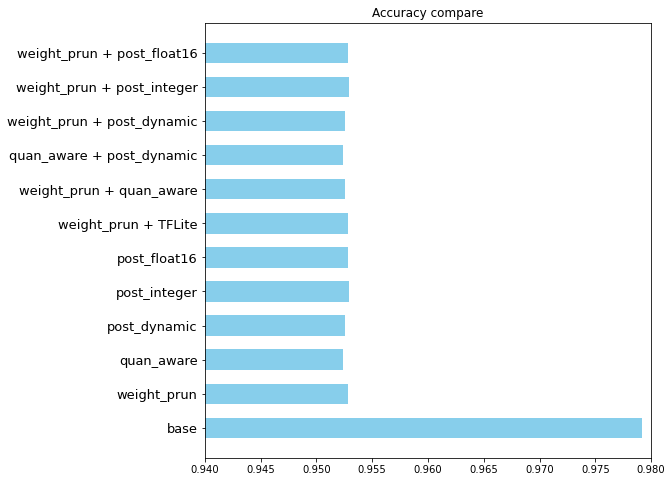

In [60]:
from matplotlib import pyplot as plt

y = [baseline_model_accuracy, model_for_pruning_accuracy,
    q_aware_model_accuracy, dynamic_post_q_accuracy,
    integer_post_q_accuracy*(1/100),
    fp16_post_q_accuracy, test_accuracy_p,
    q_aware_prun_model_accuracy, qaware_dynamic_post_q_accuracy,
    prun_dynamic_post_q_accuracy, 
    prun_integer_post_q_accuracy*(1/100),
    prun_fp16_post_q_accuracy]

x = ['base', 'weight_prun','quan_aware',
    'post_dynamic','post_integer',
    'post_float16','weight_prun + TFLite',
    'weight_prun + quan_aware','quan_aware + post_dynamic',
    'weight_prun + post_dynamic', 'weight_prun + post_integer',
    'weight_prun + post_float16']

plt.figure(figsize=(8, 8))
plt.barh(x, y, color="skyblue", height=0.6)
plt.xlim(0.94, 0.98)

plt.yticks(x,fontsize=13)
plt.title("Accuracy compare")
plt.show()

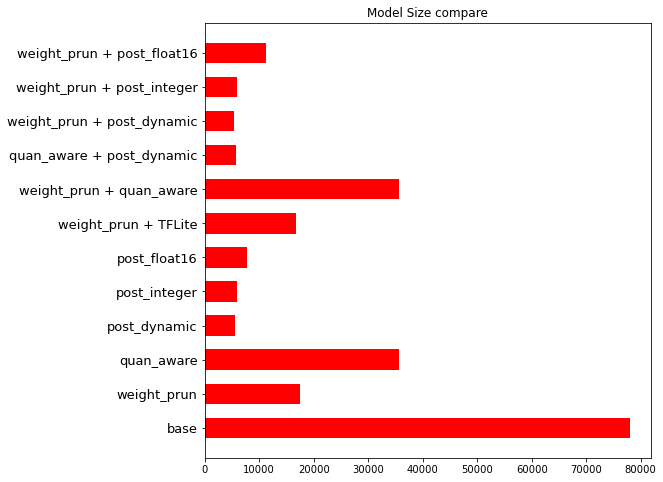

In [74]:
y = [get_gzipped_model_size(keras_file),
    get_gzipped_model_size(pruned_keras_file),
    get_gzipped_model_size(quantized_keras_file),
    get_gzipped_model_size(dynamic_post_quan_tflite_file),
    get_gzipped_model_size(integer_post_quan_tflite_file),
    get_gzipped_model_size(fp16_post_quan_tflite_file),
    get_gzipped_model_size(weightpruning_tflite_file),
    get_gzipped_model_size(pruned_and_quantized_keras_file),
    get_gzipped_model_size(qaware_dynamic_post_quan_tflite_file),
    get_gzipped_model_size(prun_dynamic_post_quan_tflite_file),
    get_gzipped_model_size(prun_integer_post_quan_tflite_file),
    get_gzipped_model_size(prun_fp16_post_quan_tflite_file)]

x = ['base', 'weight_prun','quan_aware',
    'post_dynamic','post_integer',
    'post_float16','weight_prun + TFLite',
    'weight_prun + quan_aware','quan_aware + post_dynamic',
    'weight_prun + post_dynamic', 'weight_prun + post_integer',
    'weight_prun + post_float16']

plt.figure(figsize=(8, 8))
plt.barh(x, y, color="red", height=0.6)
#plt.xlim(0.0,0.9)

plt.yticks(x,fontsize=13)
plt.title("Model Size compare")
plt.show()

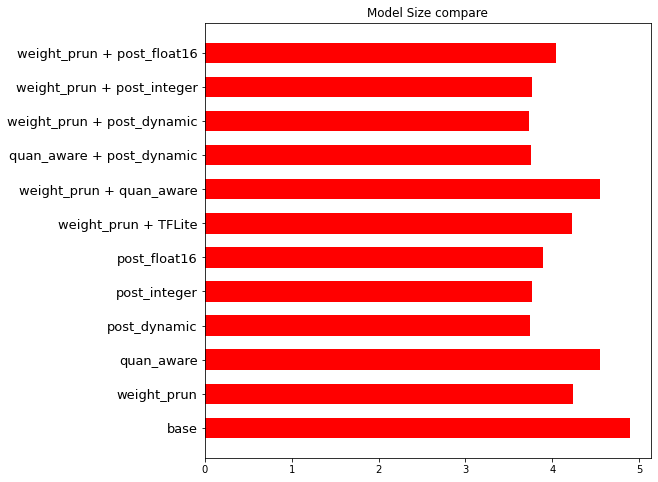

In [76]:
y=[np.log10(x) for x in y]
plt.figure(figsize=(8, 8))
plt.barh(x, y, color="red", height=0.6)
#plt.xlim(0.0,0.9)

plt.yticks(x,fontsize=13)
plt.title("Model Size compare")
plt.show()

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not ['black', 'green', 'red', 'cyan', 'yellow', 'fuchsia', 'blue', 'orange', 'brown', 'lighpink', 'lime', 'lightcoral']

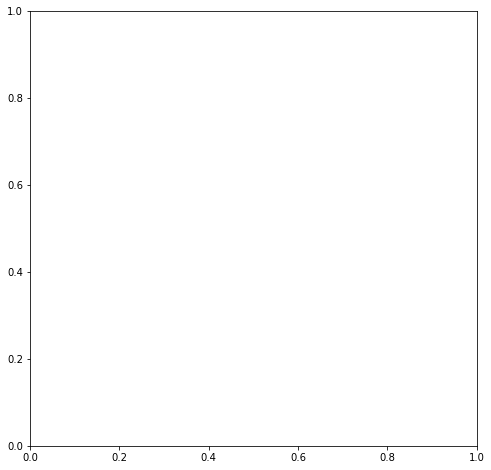

In [83]:
x = [baseline_model_accuracy, model_for_pruning_accuracy,
    q_aware_model_accuracy, dynamic_post_q_accuracy,
    integer_post_q_accuracy*(1/100),
    fp16_post_q_accuracy, test_accuracy_p,
    q_aware_prun_model_accuracy, qaware_dynamic_post_q_accuracy,
    prun_dynamic_post_q_accuracy, 
    prun_integer_post_q_accuracy*(1/100),
    prun_fp16_post_q_accuracy]

y = [get_gzipped_model_size(keras_file),
    get_gzipped_model_size(pruned_keras_file),
    get_gzipped_model_size(quantized_keras_file),
    get_gzipped_model_size(dynamic_post_quan_tflite_file),
    get_gzipped_model_size(integer_post_quan_tflite_file),
    get_gzipped_model_size(fp16_post_quan_tflite_file),
    get_gzipped_model_size(weightpruning_tflite_file),
    get_gzipped_model_size(pruned_and_quantized_keras_file),
    get_gzipped_model_size(qaware_dynamic_post_quan_tflite_file),
    get_gzipped_model_size(prun_dynamic_post_quan_tflite_file),
    get_gzipped_model_size(prun_integer_post_quan_tflite_file),
    get_gzipped_model_size(prun_fp16_post_quan_tflite_file)]

z = ['base', 'weight_prun','quan_aware',
    'post_dynamic','post_integer',
    'post_float16','weight_prun + TFLite',
    'weight_prun + quan_aware','quan_aware + post_dynamic',
    'weight_prun + post_dynamic', 'weight_prun + post_integer',
    'weight_prun + post_float16']

colors = ['black','green','red','cyan', 'yellow','fuchsia','blue','orange', 'brown','lighpink','lime','lightcoral']
# d = [(10,10),(10,10),(10,-15),(10,10),(0,-15),(10,10),(30,10),(20,10),(40,-15)]
plt.figure(figsize=(8, 8))
plt.scatter(x,y, c=colors, s=200)

# i = 0
# for xs,ys in zip(x,y):
#     plt.annotate(z[i], (xs,ys), textcoords="offset points",xytext=d[i],ha='right')
#     i += 1
plt.ylabel('Model Size')
plt.xlabel('Accuracy')
plt.show()